In [16]:
from qbm_utils import *
from qiskit.quantum_info import Pauli
from qiskit.extensions import UGate, RZZGate

### Quantum enhanced MCMC implementation
Aim is to implement the circuit for implementing quantum enhanced MCMC

In [52]:
## put n_spins even always
n_spins = 10

## construct problem Hamiltonian ##
J = np.random.uniform(low= -1, high= 1, size= (n_spins, n_spins) )
J = 0.5 * (J + J.transpose() )

h = np.random.uniform(low= -1, high = 1, size= (n_spins))
alpha = np.sqrt(n_spins) / np.sqrt( sum([J[i][j]**2 for i in range(n_spins) for j in range(i)]) + sum([h[j]**2 for j in range(n_spins)])  )

In [53]:
def construct_h1(a:float, b:float, time:float= 1.00 ):
    """ Function to construct a circuit implementing single qubit unitaries
        i.e;  H1_i = a_i * X_i + b_i * Z_i

        ARGS:
        ----
            a: [float] 
                Coefficient of 'X' operator

            b: [float] 
                Coefficient of 'Z' operator
            
            time: Optional[float]
                  Time of evolution while implemnting using 'HamiltonianGate' class 
        
        RETURNS:
        -------
            qiskit.HamiltonianGate object 

    """

    return HamiltonianGate( a * Pauli('X').to_matrix() + b * Pauli('Z').to_matrix(), time )


def construct_h2(J:float, time:float = 1.00 ):
    """ Function to construct circuit implmenting RZZ rotations 

    """
    pass

In [54]:
def append_evolution(qc:QuantumCircuit, h:np.array , J:np.array, gamma:float, alpha:float, time:float, is_terminal_step= False):

    for qubit in range(len(qc.qubits)):
        qc.append(HamiltonianGate( gamma * Pauli('X').to_matrix() + (1 - gamma) * alpha * h[qubit] * Pauli('Z').to_matrix(), time, label= 'h_'+str(qubit) ), [ qc.qubits[qubit]] )
    
    if not is_terminal_step:    
        for qubit in range( 0, len(qc.qubits), 2):
            qc.append( RZZGate(J[qubit][qubit+1], label= 'J_'+str(qubit)+str(qubit+1)), [qc.qubits[qubit], qc.qubits[qubit+1]]  )
        for qubit in range( 1, len(qc.qubits)-1 , 2):
            qc.append( RZZGate(J[qubit][qubit+1], label= 'J_'+str(qubit)+str(qubit+1)), [qc.qubits[qubit], qc.qubits[qubit+1]]  )
    
    qc.barrier()
    return qc

In [64]:
spins = QuantumRegister(n_spins, name= 'spin')
creg_init = ClassicalRegister(n_spins, name= 'creg_0')
creg_final = ClassicalRegister(n_spins, name= 'creg_f')

qc = QuantumCircuit(spins, creg_init, creg_final)
qc.h(spins)
qc.barrier()

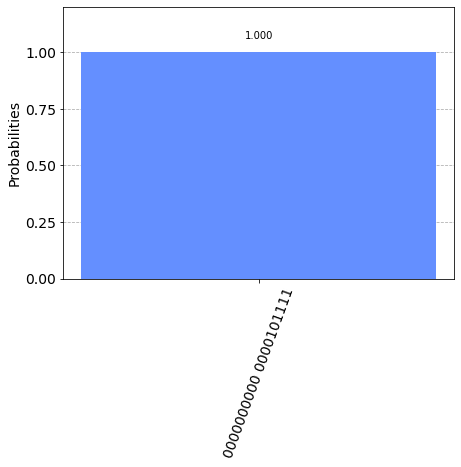

In [65]:
qc_i = qc.copy()
qc_i.measure(spins, creg_init)
plot_histogram( execute(qc_i, shots= 1, backend= qsm).result().get_counts() )

In [66]:
num_trotter_steps = 3
for step in range(num_trotter_steps):
    append_evolution(qc, h, J, gamma= np.random.random(), alpha= alpha, time= 0.8)
append_evolution(qc, h, J, gamma= 0.1, alpha= alpha, time= 0.8, is_terminal_step= True)

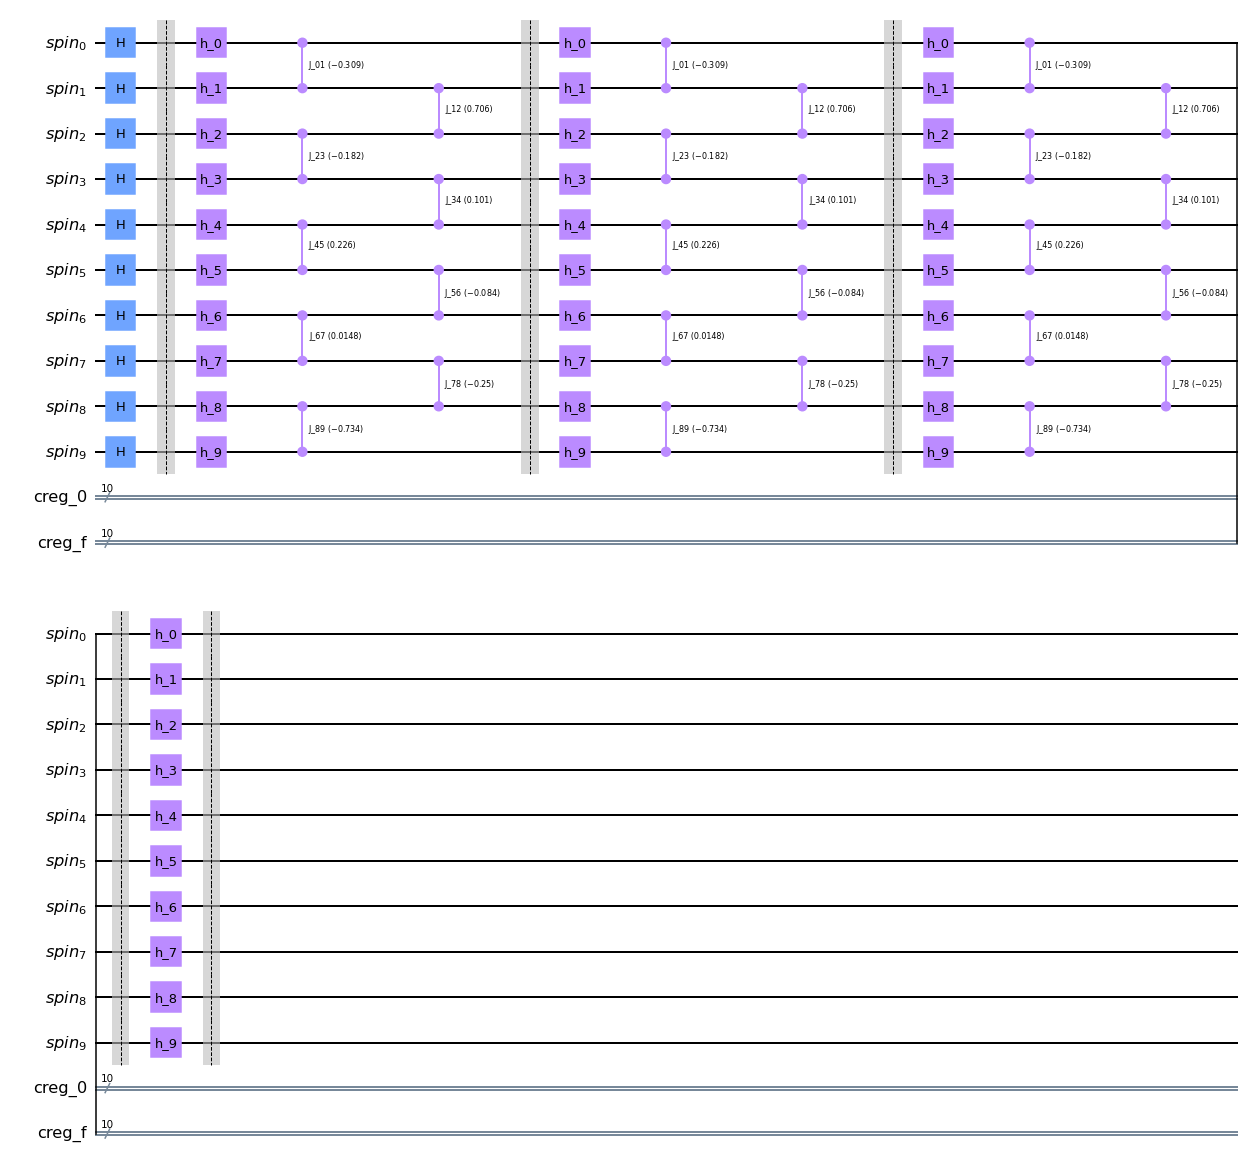

In [67]:
qc.draw(output= 'mpl')

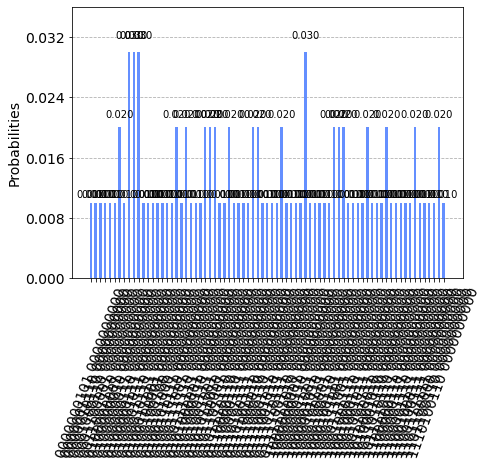

In [69]:
qc_i = qc.copy()
qc_i.measure(spins, creg_final)
plot_histogram( execute(qc_i, shots= 100, backend= qsm).result().get_counts() )